<a href="https://colab.research.google.com/github/shasitha33/Cohort-21/blob/main/Fellowship_Shared.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Hi there! 🙋‍♂️	I'm [Supun](https://www.linkedin.com/in/supun-weerakoon/)

> In this Notebook I will walk through how to do Sentiment analysis using XLNet 😀

> Due to resource limitations, I trained the model 

      *   Using only 0.13 % of total data (4,000 data points out of 3,000,000) 👨‍💻
      *   Using only 3 Training epoches 👨‍💻

> Under these constraints final model accuracy on test data is **95 %**

> References can be found at the end of the notebook





#Exploratory Data Analysis (EDA)

###Import Libraries

In [ ]:
# Import libraries that is need to run the EDA Section
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display, HTML
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import re

print(f"\nCell Executed On : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")


Cell Executed On : 2021-12-14 12:39:44



###Data Extraction

In [ ]:
# Read data in to pandas dataframes from data source 
ORIGINAL_TRAIN_DATA_PATH = '/content/Fellowship/Data/amazon_review_full_csv/train.csv'
ORIGINAL_TEST_DATA_PATH = '/content/Fellowship/Data/amazon_review_full_csv/test.csv'

df_train = pd.read_csv(ORIGINAL_TRAIN_DATA_PATH, header=None)
df_test = pd.read_csv(ORIGINAL_TEST_DATA_PATH, header=None)

print(f"\nCell Executed On : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")


Cell Executed On : 2021-12-14 12:40:31





*   Printing Test & Train data sets will be a common task true out this notebook.
*   Therefore let's define function to avoid repetition of codes.

In [ ]:
# Function to print train & test functions

def print_dfs(df_train,df_test):
  print('\nTraining Dataset Sample: \n')
  display(df_train.head(2))
  print('\nTest Dataset Sample: \n')
  display(df_test.head(2))

In [ ]:
# Print output at the end of process for clarification
print_dfs(df_train,df_test)


Training Dataset Sample: 



,0,1,2
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...



Test Dataset Sample: 



,0,1,2
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...


###Data Analysis

In [ ]:
# Take a copy of dataframes to do changes
dfc_train = df_train.copy()
dfc_test = df_test.copy()

# Rename column names to your friendly manner in both train & test datasets
dfc_train.rename(columns={0:'Rating',1:'Review Title',2:'Review Text'},inplace=True)
dfc_test.rename(columns={0:'Rating',1:'Review Title',2:'Review Text'},inplace=True)

# Print output at the end of process for clarification
print_dfs(dfc_train,dfc_test)


Training Dataset Sample: 



,Rating,Review Title,Review Text
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...



Test Dataset Sample: 



,Rating,Review Title,Review Text
0,1,mens ultrasheer,"This model may be ok for sedentary types, but ..."
1,4,Surprisingly delightful,This is a fast read filled with unexpected hum...


Statistics About Dataset

In [ ]:
# Lets explore some statistics about datasets
print('\nTraining Dataset Information: \n')
display(dfc_train.describe())

print('\nTest Dataset Information: \n')
display(dfc_test.describe())


Training Dataset Information: 



,Rating
count,3.000000e+06
mean,3.000000e+00
std,1.414214e+00
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,4.000000e+00
max,5.000000e+00



Test Dataset Information: 



,Rating
count,650000.000000
mean,3.000000
std,1.414215
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


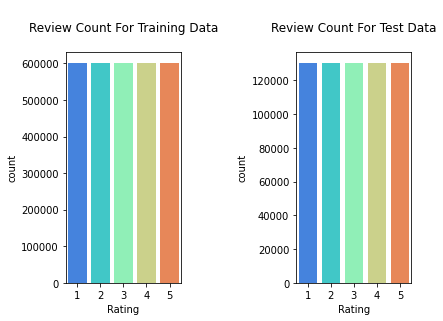

In [ ]:
# Let's look at review counts of each ratings for train and test data sets
fig, axs = plt.subplots(ncols=2)
sns.countplot(x='Rating',data=dfc_train,palette='rainbow',ax=axs[0]).set(title='\nReview Count For Training Data\n')
sns.countplot(x='Rating',data=dfc_test,palette='rainbow',ax=axs[1]).set(title='\nReview Count For Test Data\n')
plt.subplots_adjust(left=0.1, bottom=0.1,right=0.9,top=0.9,wspace=1, hspace=0.4)
plt.show()



*   From the results it is clear that train set has total 3,000,000 records and test set has 650,000 records.
*   Each Rating got same number of reviews. So dataset is balanced and we do not need to do imbalanced data handling


In [ ]:
#Lets check dataset is imbalance or not
print('\nTrain Dataset Review Count per Each Rating: \n')
display(dfc_train.groupby(by=['Rating']).count())

print('\nTest Dataset Review Count per Each Rating: \n')
display(dfc_test.groupby(by=['Rating']).count())


Train Dataset Review Count per Each Rating: 



,Review Title,Review Text
Rating,,
1,599988,600000
2,599977,600000
3,599977,600000
4,599987,600000
5,599995,600000



Test Dataset Review Count per Each Rating: 



,Review Title,Review Text
Rating,,
1,129999,130000
2,129999,130000
3,129999,130000
4,129996,130000
5,129995,130000


*   We can see some reviews do not contain Titles.
*   Titles of reviews are short & sometimes it can be misleading. (Ex: "Bought Yesterday. Returned Today.")
*   Therefore it is good practice to drop Title column and move forward.

###Data pre-processing

In [ ]:
# Drop "Review Title" column from dataframes
dfc_train.drop('Review Title',axis=1,inplace=True)
dfc_test.drop('Review Title',axis=1,inplace=True)

# Print output at the end of process for clarification
print_dfs(dfc_train,dfc_test)


Training Dataset Sample: 



,Rating,Review Text
0,3,Gave this to my dad for a gag gift after direc...
1,5,I hope a lot of people hear this cd. We need m...



Test Dataset Sample: 



,Rating,Review Text
0,1,"This model may be ok for sedentary types, but ..."
1,4,This is a fast read filled with unexpected hum...



*   We can use Easy Data Augmentation (EDA) Techniques to generate more data & avoid overfitting.
*   But we have 3 million data to process.
*   So we can skip using Easy Data Augmentation Techniques (EDA).


> Due to resource limitations I decided to downsample the data set in below methode.


* Only consider Rating 1 as Negative Sentiment Class & Rating 5 as Positive Sentiment Class.
* Drop reviews related to rating 2,3 & 4.
* Even after that train dataset contains total of 1,200,000 reviews. 
* So I downsample further by considering only 2,000 reviews from each class.
* If the model accuracy is low then I will increase this sample size and retrain the model.


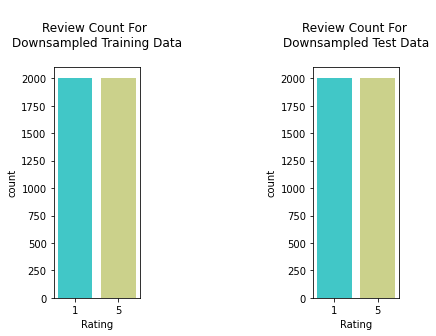

In [ ]:
# Downsampling to meet resource limitations.
SAMPLE_SIZE = 2000 # We can increase this value if the model performance is bad.

shuffle_train_rating_1 = dfc_train[dfc_train['Rating']==1].sample(n=SAMPLE_SIZE,random_state=33).reset_index(drop=True)
shuffle_train_rating_5 = dfc_train[dfc_train['Rating']==5].sample(n=SAMPLE_SIZE,random_state=33).reset_index(drop=True)
shuffle_test_rating_1 = dfc_test[dfc_test['Rating']==1].sample(n=SAMPLE_SIZE,random_state=33).reset_index(drop=True)
shuffle_test_rating_5 = dfc_test[dfc_test['Rating']==5].sample(n=SAMPLE_SIZE,random_state=33).reset_index(drop=True)

train_df = pd.concat([shuffle_train_rating_1,shuffle_train_rating_5]).sample(frac=1,random_state=33).reset_index(drop=True)
test_df = pd.concat([shuffle_test_rating_1,shuffle_test_rating_5]).sample(frac=1,random_state=33).reset_index(drop=True)

# Let's look at review counts of each ratings for train and test data sets
fig, axs = plt.subplots(ncols=2)
sns.countplot(x='Rating',data=train_df,palette='rainbow',ax=axs[0]).set(title='\nReview Count For \nDownsampled Training Data\n')
sns.countplot(x='Rating',data=test_df,palette='rainbow',ax=axs[1]).set(title='\nReview Count For \nDownsampled Test Data\n')
plt.subplots_adjust(left=0.1, bottom=0.1,right=0.9,top=0.9,wspace=2, hspace=0.4)
plt.show()

> Now It's Time To Do Text Cleaning !

*   Replace Rating 1 lable in to "Negative" lable
*   Replace Rating 5 lable in to "Positive" lable
*   Remove tags from "Review Text"
*   Remove hyperlinks from "Review Text"
*   Remove emojis from "Review Text"
*   Remove numerical characters from "Review Text"
*   Remove tabs from "Review Text"
*   Remove extra spaces from "Review Text"

In [ ]:
#Replace Rating "1" in to "Negative" lable & Replace Rating "5" in to "Positive" lable

train_df['Rating'] = train_df['Rating'].apply(lambda x : 'Positive' if x==5 else 'Negative')
test_df['Rating'] = test_df['Rating'].apply(lambda x : 'Positive' if x==5 else 'Negative') 

# Print output at the end of process for clarification
print_dfs(train_df,test_df)


Training Dataset Sample: 



,Rating,Review Text
0,Negative,For the most part these remixes lack even an i...
1,Positive,This book deals with situations where we sabot...



Test Dataset Sample: 



,Rating,Review Text
0,Negative,"If I could give it 0 stars, I would. All the l..."
1,Positive,I have had three children and after each pregn...


Cleaning Text Data

In [ ]:
# Function to clean review texts
def clean_text(text):
    text = re.sub(r"@[A-Za-z0-9]+", ' ', text)  # remove tag names
    text = re.sub('http[s]?://\S+', '', text)  # remove hyperlinks 
    text = re.sub(r"[^a-zA-z.!?'0-9]", ' ', text)  # remove emojis
    text = re.sub(r"[^a-zA-z]", ' ', text)  # remove numerical characters
    text = re.sub('\t', ' ',  text)  # remove tabs
    text = re.sub(r" +", ' ', text)  # remove extra spaces
    return text.lower()

# Let's test above function
test_review = '@Supun Can you #go to this web--adress with 33 seconds? :-) https://www.SupunWeerakoon./33 & user name is Kandy33'
print(f'Input To Function: \n{test_review}')
print('\nOutput Of Function: ')
clean_text(test_review)

Input To Function: 
@Supun Can you #go to this web--adress with 33 seconds? :-) https://www.SupunWeerakoon./33 & user name is Kandy33

Output Of Function: 


' can you go to this web adress with seconds user name is kandy '

In [ ]:
# Clean Review Text
train_df['Review Text'] = train_df['Review Text'].apply(clean_text)
test_df['Review Text'] = test_df['Review Text'].apply(clean_text)

# Print output at the end of process for clarification
print_dfs(train_df,test_df)

# Save this data set for future use.
train_df.to_csv('Train.csv',index=False)
test_df.to_csv('Test.csv',index=False)


Training Dataset Sample: 



,Rating,Review Text
0,Negative,for the most part these remixes lack even an i...
1,Positive,this book deals with situations where we sabot...



Test Dataset Sample: 



,Rating,Review Text
0,Negative,if i could give it stars i would all the lids ...
1,Positive,i have had three children and after each pregn...


#XLNet Model

###Setup Environment 

In [ ]:
!nvidia-smi

Tue Dec 14 12:49:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install sentencepiece transformers

In [ ]:
import sentencepiece
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
from transformers import XLNetForSequenceClassification

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display, HTML
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import rc
import re

import torch
from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 33
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

###Load Data

In [ ]:
# Setting file paths

CLEAN_TRAIN_DATA_PATH = '/content/drive/Fellowship/Data/Train.csv'
CLEAN_TEST_DATA_PATH = '/content/drive/Fellowship/Data/Test.csv'

df_train = pd.read_csv(CLEAN_TRAIN_DATA_PATH)
df_test = pd.read_csv(CLEAN_TEST_DATA_PATH)

# Function to print train & test functions

def print_dfs(df_train,df_test):
  print('\nTraining Dataset Sample: \n')
  display(df_train.head(2))
  print('\nTest Dataset Sample: \n')
  display(df_test.head(2))

print_dfs(df_train,df_test) # Function is defined in EDA section as well


Training Dataset Sample: 



,Rating,Review Text
0,Negative,for the most part these remixes lack even an i...
1,Positive,this book deals with situations where we sabot...



Test Dataset Sample: 



,Rating,Review Text
0,Negative,if i could give it stars i would all the lids ...
1,Positive,i have had three children and after each pregn...


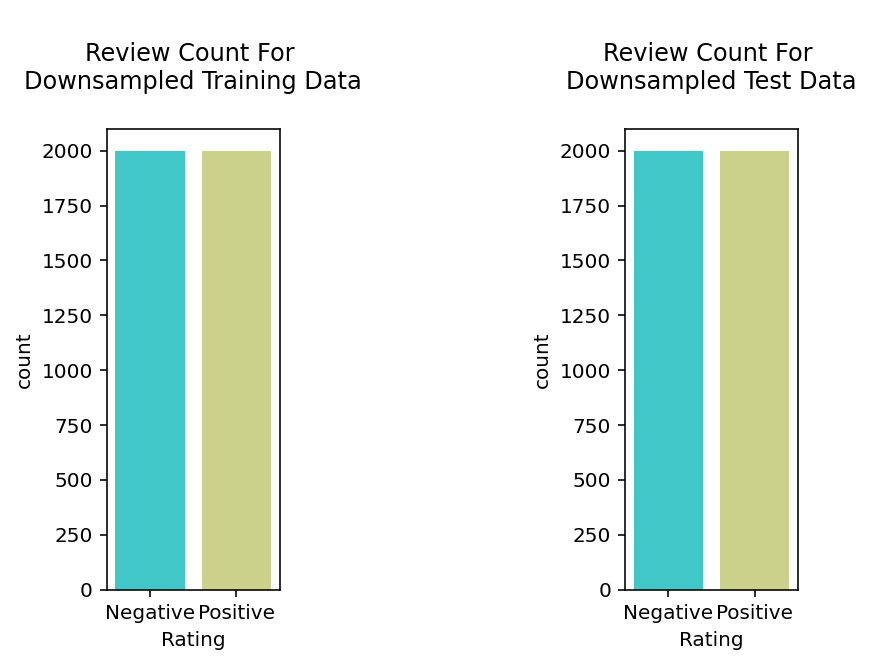

In [ ]:
# Let's look at review counts of each ratings for train and test data sets
fig, axs = plt.subplots(ncols=2)
sns.countplot(x='Rating',data=df_train,palette='rainbow',ax=axs[0]).set(title='\nReview Count For \nDownsampled Training Data\n')
sns.countplot(x='Rating',data=df_test,palette='rainbow',ax=axs[1]).set(title='\nReview Count For \nDownsampled Test Data\n')
plt.subplots_adjust(left=0.1, bottom=0.1,right=0.9,top=0.9,wspace=2, hspace=0.4)
plt.show()


Encode "Negative" Label to 0 & "Positive" Label to 1



In [ ]:
df_train['Rating'] = df_train['Rating'].apply(lambda x : 1 if x=='Positive' else 0)
df_test['Rating'] = df_test['Rating'].apply(lambda x : 1 if x=='Positive' else 0)
class_names = ['Negative', 'Positive']
print_dfs(df_train,df_test) # Function is defined in EDA section


Training Dataset Sample: 



,Rating,Review Text
0,0,for the most part these remixes lack even an i...
1,1,this book deals with situations where we sabot...



Test Dataset Sample: 



,Rating,Review Text
0,0,if i could give it stars i would all the lids ...
1,1,i have had three children and after each pregn...


[Huggingface transformer’s XLNetTokenizer](https://huggingface.co/transformers/v2.11.0/model_doc/xlnet.html) is used as the base pretrained model

In [ ]:
PRE_TRAINED_MODEL = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(PRE_TRAINED_MODEL)

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

To set value for maximum sequence length, we need to know the distribution of token lengths.

Text(0.5, 0, 'Number of Tokens per Review')

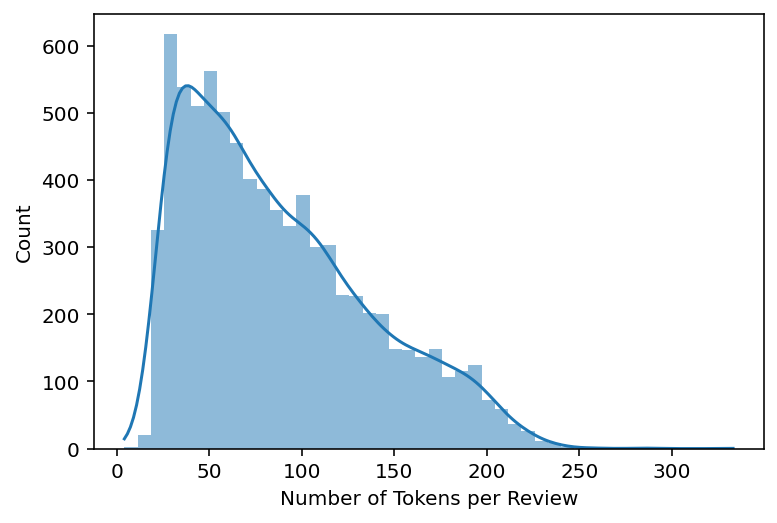

In [ ]:
# Checking the distribution of token lengths
token_lengths = []

for text in df_train['Review Text']:
  tokens = tokenizer.encode(text)
  token_lengths.append(len(tokens))

for text in df_test['Review Text']:
  tokens = tokenizer.encode(text)
  token_lengths.append(len(tokens))

sns.histplot(token_lengths, kde=True, linewidth=0)
plt.xlabel('Number of Tokens per Review')

According to above distribution we can set maximum **effective** length value to 200

In [ ]:
MAX_LEN = 200 # Lets ignore the small percentage that has length more than 200. Those will be truncated.

###Model Training

Building iterator class from pytorch [Dataset & DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) class is needed to feed data to transformers.

In [ ]:
# Dataset object class is created as below

class Custom_Dataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        
        # To encode and pad data in tokenized form we can use encode_plus() function from Huggingface transformer’s XLNetTokenizer
        encoding = self.tokenizer.encode_plus(review, add_special_tokens=True, max_length=self.max_len, return_token_type_ids=False,
                                              pad_to_max_length=False, return_attention_mask=True, return_tensors='pt')
        
        # encode_plus() function returns input_ids, attention_mask and if required token_type_ids. We can customize them as below
        input_ids = pad_sequences(encoding['input_ids'], maxlen=self.max_len, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=self.max_len, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {'review_text': review, 
                'input_ids': input_ids, 
                'attention_mask': attention_mask.flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

# Function to create DataLoader object

def create_data_loader(df, tokenizer, max_len, batch_size):
  
  dataset_object = Custom_Dataset(reviews=df['Review Text'].to_numpy(), targets=df['Rating'].to_numpy(), tokenizer=tokenizer, max_len=max_len)
  return DataLoader(dataset_object,batch_size=batch_size,num_workers=2) #Colab support maximum 2 workers.

Generating validation data set from test data set is essential to improve model performance

In [ ]:
df_train = df_train
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=33)
print(f'Train set shape : {df_train.shape}\nValidation set shape : {df_val.shape}\nTest set shape : {df_test.shape}')

Train set shape : (4000, 2)
Validation set shape : (1000, 2)
Test set shape : (1000, 2)


* Create Data loaders for Train, Test & Validation datasets.
* Create the XLNet Model

In [ ]:
BATCH_SIZE = 2 #Since n_workers in dataloader is 2, I have used same batch size

# Create data loaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

# Create XLNet model
model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels = 2)
model = model.to(device)

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a



> Set Hyperparameters to XLNet Model training process
* optimizer
* total number of steps
* scheduler



In [ ]:
EPOCHS = 3

#define parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_params = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}]

optimizer = AdamW(optimizer_grouped_params, lr=3e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Define Training Step Function

In [ ]:
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples, batch_size, max_len):
    model = model.train()
    losses = []
    acc = 0
    counter = 0

    # below loop calculate accuracy and loss for each item in data_loader. Then add them to acc & losses variables defined above
    for dtl in data_loader:
        input_ids = dtl["input_ids"].reshape(batch_size,max_len).to(device)
        attention_mask = dtl["attention_mask"].to(device)
        targets = dtl["targets"].to(device)
        
        # calculate loss
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]
        
        # calculate accuracy for individual data item
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        # adding individual accuracy and loss values to total values
        acc += accuracy
        losses.append(loss.item())  
        counter = counter + 1 # to know the number of items in data_loader

        # model parameters are trained and adjusted according to each data item in data_loader
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()       

    return acc / counter, np.mean(losses)

Define Evaluation Function

In [ ]:
# This function is similar to training step function except model parameter tuning section

def eval_model(model, data_loader, device, n_examples, batch_size, max_len):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for dtl in data_loader:
            input_ids = dtl["input_ids"].reshape(batch_size, max_len).to(device)
            attention_mask = dtl["attention_mask"].to(device)
            targets = dtl["targets"].to(device)
            
            # calculate loss
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]
            
            # calculate accuracy for individual data item
            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)
            
            # adding individual accuracy and loss values to total values
            acc += accuracy
            losses.append(loss.item())
            counter += 1  # to know the number of items in data_loader

    return acc / counter, np.mean(losses)

Fine Tuning the pre-trained model

In [ ]:
# Define variables to save model performances
history = defaultdict(list)
best_accuracy = 0
MODEL_SAVED_PATH = f'/content/drive/Fellowship/Model/xlnet_model_{MAX_LEN}.bin'

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 20)

    # Train model on train data set for given number of epoches
    train_acc, train_loss = train_epoch(model, train_data_loader, optimizer, device, scheduler, len(df_train), BATCH_SIZE, MAX_LEN)
    # Evaluate model on validation data set for given number of epoches
    val_acc, val_loss = eval_model(model, val_data_loader, device, len(df_val), BATCH_SIZE, MAX_LEN)

    print(f'\nTrain loss {train_loss} Train accuracy {train_acc}\n')   
    print(f'\nVal loss {val_loss} Val accuracy {val_acc}\n')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save validation accuracy only if it is higher than best accuracy so far
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), MODEL_SAVED_PATH) 
        best_accuracy = val_acc

Epoch 1/3
--------------------

Train loss 0.4636683730442019 Train accuracy 0.90525


Val loss 0.3293987659356208 Val accuracy 0.942

Epoch 2/3
--------------------

Train loss 0.17768379596312114 Train accuracy 0.971


Val loss 0.3415179365466029 Val accuracy 0.949

Epoch 3/3
--------------------

Train loss 0.08222632281164442 Train accuracy 0.98775


Val loss 0.29740461907849386 Val accuracy 0.957



Evaluate Final Model

In [ ]:
# Load best model
model.load_state_dict(torch.load(MODEL_SAVED_PATH)) 
model = model.to(device)

# Test model on test data set
test_acc, test_loss = eval_model(model, test_data_loader, device, len(df_test), BATCH_SIZE, MAX_LEN)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.948
Test Loss : 0.4077145253716517


###Model Testing

In [ ]:
def get_predictions(model, data_loader, batch_size, max_len):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for dtl in data_loader:
            texts = dtl["review_text"]
            input_ids = dtl["input_ids"].reshape(batch_size, max_len).to(device)
            attention_mask = dtl["attention_mask"].to(device)
            targets = dtl["targets"].to(device)
            
            # Calculate loss for each data point in data_loader
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            # Geting probability of each class using softmax function
            _, preds = torch.max(outputs[1], dim=1)
            probs = F.softmax(outputs[1], dim=1)
            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

Model performance on Test set

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions( model, test_data_loader, BATCH_SIZE, MAX_LEN)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.93      0.96      0.95       470
    Positive       0.96      0.94      0.95       530

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



Model prediction on raw text

In [ ]:
# Below function gives the model prediction on raw text

def predict_sentiment(text):
    review_text = text

    # To encode and pad data in tokenized form we can use encode_plus() function from Huggingface transformer’s XLNetTokenizer
    encoded_review = tokenizer.encode_plus(review_text, max_length=MAX_LEN, add_special_tokens=True, return_token_type_ids=False,
                                           pad_to_max_length=False, return_attention_mask=True, return_tensors='pt')

    # encode_plus() function returns input_ids, attention_mask and if required token_type_ids. We can customize them as below
    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.reshape(1,MAX_LEN).to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print(f"Positive score: {round(probs[1],6)*100} %")
    print(f"Negative score: {round(probs[0],6)*100} %")
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
sample_text = "These items should be banned from earth. Product quality gives us headaches"
predict_sentiment(sample_text)

Positive score: 0.0043 %
Negative score: 99.9957 %
Review text: These items should be banned from earth. Product quality gives us headaches
Sentiment  : Negative


In [ ]:
sample_text = "I have second thoughts."
predict_sentiment(sample_text)

Positive score: 0.0955 %
Negative score: 99.9045 %
Review text: I have second thoughts.
Sentiment  : Negative


#Reference



> These are the references that I used to build this notebook. 🤗


> I take this as an opportunity to thank them all for sharing their knowledge throughout the world. 🙏

*   [David Mertz's Work](https://developer.ibm.com/articles/l-pycon/)
*   [Suleiman Khan's Work](https://towardsdatascience.com/bert-roberta-distilbert-xlnet-which-one-to-use-3d5ab82ba5f8)
*   [Jay Alammar's Work](http://jalammar.github.io/illustrated-transformer/)
*   [Jason Wei's Work](https://github.com/jasonwei20/eda_nlp)
*   [Josh Xin Jie Lee's Work](https://towardsdatascience.com/multi-label-text-classification-with-xlnet-b5f5755302df)
*   [Shanay Ghag's Work](https://medium.com/swlh/using-xlnet-for-sentiment-classification-cfa948e65e85)
*   [Zihang Dai's Work](https://github.com/zihangdai/xlnet)
*   [Huggingface XLNet Transformer](https://huggingface.co/transformers/v2.11.0/model_doc/xlnet.html)